# Inspect Dataset of Kaggle Contest
Contest website: https://www.kaggle.com/c/spooky-author-identification/overview

In [58]:
import pandas as pd
import gensim
import seaborn

from wordcloud import WordCloud

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()


### BEGIN settings of pyLDAvis ### 
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
### END settings of pyLDAvis ###

Loading BokehJS ...

In [2]:
import spacy
!python -m spacy download en_core_web_sm
!python -m spacy validate

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Loaded compatibility table

====================== Installed models (spaCy v2.1.4) ======================
ℹ spaCy installation:
/home/ec2-user/anaconda3/lib/python3.7/site-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-sm   en_core_web_sm   2.1.0   ✔



In [17]:
filename_dataset = './datasets/train.csv'
dataset_df = pd.read_csv(filename_dataset)

In [4]:
dataset_df.shape

(19579, 3)

In [5]:
dataset_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


# Check Duplicate ID

In [6]:
len(set(dataset_df['id']))

19579

# Find the Maxmum/Minimum Length of Test

In [7]:
len_max = 0
index_max = 0

len_min = 999999
index_min = 0

for index, text in enumerate(dataset_df['text']):
    length = len(text.split())
    
    if len_max < length:
        len_max =  length
        index_max = index
    elif len_min > length:
        len_min= length
        index_min = index


print('Min number of tokens={} at index {}'.format(len_min, index_min))
print('Author: {}'.format(dataset_df['author'][index_min]))
print(dataset_df['text'][index_min])
print()
print('Max number of tokens={} at index {}'.format(len_max, index_max))
print('Author: {}'.format(dataset_df['author'][index_max]))
print(dataset_df['text'][index_max][:500])


Min number of tokens=2 at index 6936
Author: EAP
"PIQUANT EXPRESSIONS.

Max number of tokens=861 at index 9215
Author: MWS
Diotima approached the fountain seated herself on a mossy mound near it and her disciples placed themselves on the grass near her Without noticing me who sat close under her she continued her discourse addressing as it happened one or other of her listeners but before I attempt to repeat her words I will describe the chief of these whom she appeared to wish principally to impress One was a woman of about years of age in the full enjoyment of the most exquisite beauty her golden hair floated in r


# Plot Histogram of the Number of Tokens

In [20]:
lengths = []
for d in dataset_df['text']:
    lengths.append(len(d.split()))

In [24]:
dataset_df.insert(loc=3, column='token_cnt', value=lengths)

In [25]:
dataset_df.head()

,id,text,author,token_cnt
0,id26305,"This process, however, afforded me no means of...",EAP,41
1,id17569,It never once occurred to me that the fumbling...,HPL,14
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27


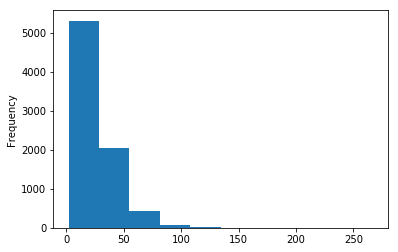

In [33]:
index = dataset_df['author'] == 'EAP'
dataset_df['token_cnt'][index].plot.hist()

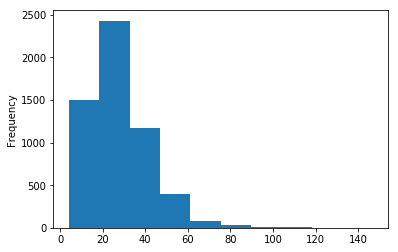

In [34]:
index = dataset_df['author'] == 'HPL'
dataset_df['token_cnt'][index].plot.hist()

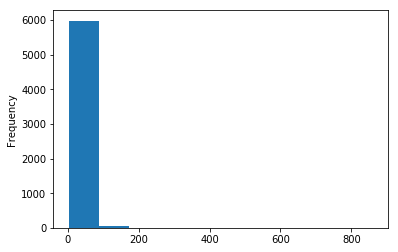

In [35]:
index = dataset_df['author'] == 'MWS'
dataset_df['token_cnt'][index].plot.hist()

# Check Authors

In [36]:
print(set(dataset_df['author']))

{'MWS', 'HPL', 'EAP'}


In [37]:
value_counts_author = dataset_df['author'].value_counts()
print(type(value_counts_author))
print(value_counts_author)

<class 'pandas.core.series.Series'>
EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


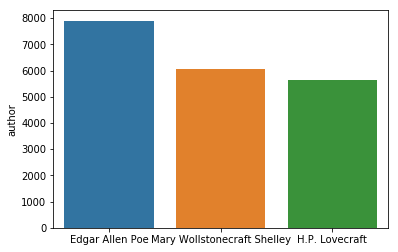

In [38]:
seaborn.barplot(x=['Edgar Allen Poe', 'Mary Wollstonecraft Shelley', 'H.P. Lovecraft'],
                y=dataset_df['author'].value_counts())

# Preprocess using Spacy

In [39]:
def normalizer(dataset):
    """
    Normalize data
    
    Args:
        dataset (list(str))
    """
    for d in dataset:
        yield d.lower()
        
        
def preprocess(doc):
    """
    Remove stopwords, punctuations, numbers, and lemmatize
    Args:
        doc (spacy.tokens.doc.Doc)
    """
    
    tokens = [token.lemma_ for token in doc if token.pos_ not in ('NUM', 'PUNCT') and not token.is_stop]

    return tokens

In [40]:
# Disable NER (Named Entity Recognizer) and Parser (Dependence Parser)
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [41]:
batch_size = 100
dataset = dataset_df['text']

%time texts = [preprocess(doc) for doc in nlp.pipe(normalizer(dataset), batch_size=batch_size, n_threads=-1)]

CPU times: user 20.6 s, sys: 17.7 ms, total: 20.6 s
Wall time: 20.7 s


In [42]:
print(texts[0])

['process', 'afford', 'means', 'ascertain', 'dimension', 'dungeon', 'circuit', 'return', 'point', 'set', 'aware', 'fact', 'perfectly', 'uniform', 'wall']


In [43]:
print(texts[1])

['occur', 'fumbling', 'mere', 'mistake']


# Plot WordCloud based on all documents

In [44]:
all_texts = ' '.join([d for d in dataset_df['text']])

In [45]:
len(all_texts)

2937973

In [46]:
all_texts[:100]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might'

<class 'wordcloud.wordcloud.WordCloud'>


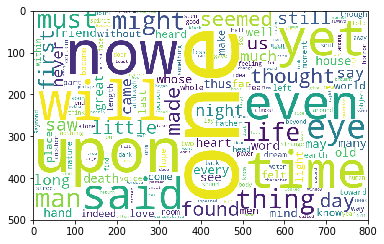

In [47]:
wordcloud = WordCloud(background_color='white',
                         width=800, height=500,
                        random_state=0).generate(all_texts)

print(type(wordcloud))
plt.imshow(wordcloud)

# Plot WordCloud after Preprocessing

In [48]:
texts[1]

['occur', 'fumbling', 'mere', 'mistake']

In [49]:
all_tokens = ' '.join(' '.join(t) for t in texts)

In [50]:
all_tokens[:100]

'process afford means ascertain dimension dungeon circuit return point set aware fact perfectly unifo'

In [51]:
wordcloud = WordCloud(background_color='white',
                     width=800, height=500,
                     random_state=0).generate(all_tokens)

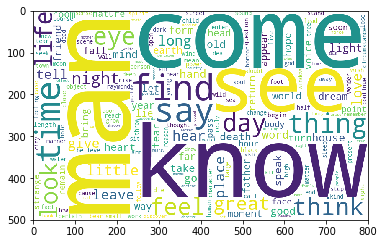

In [52]:
plt.imshow(wordcloud)

# Topic Modeling

In [54]:
def create_dictionary(docs):
    """
    Create dictionary
    
    Args:
        docs (list(list(str)))
        
    Returns:
        dictionary (gensim.corpora.Dictionary)
    """
    
    
    return gensim.corpora.Dictionary(docs)


def get_corpus_bow(docs, dictionary):
    """
    Convert texts to encoded bows using dictionary
    
    Args:
        docs (list(list(str))):
        dictionary (gensim.corpora.Dictionary)
        
    Returns:
        bows (list(list(tuple(token_id, token_count))))
    """
    bows= [dictionary.doc2bow(d) for d in docs]
    return bows


def get_corpus_tfidf(corpus_bow):
    tfidf_model = gensim.models.TfidfModel(corpus_bow)
    corpus_tfidf = tfidf_model[corpus_bow]
    
    return corpus_tfidf, tfidf_model

In [56]:
docs = texts

%time dictionary = create_dictionary(docs)
print('Size of unfiltered dictionary: {}'.format(len(dictionary)))

Size of unfiltered dictionary: 19094


In [ ]:
corpus_bow = get_corpus_bow(docs, dictionary)
%time corpus_tfidf, tfidf_model = get_corpus_tfidf(corpus_bow)

In [ ]:
num_topics = 3
passes = 5

%time lda_model_tfidf = gensim.models.LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=passes)

# Display Key Factors of Each Topic

In [63]:
def get_keywords_df(model):
    init_values = [['']*num_topics]*10
    keywords_df = pd.DataFrame(init_values, columns=['topic{}'.format(i) for i in range(num_topics)])


    for i_topic, topic in model.show_topics(-1, formatted=False):
        for i_word, (word, weight) in enumerate(topic):
            keywords_df.iloc[i_word][i_topic] = word
            
    return keywords_df


def plot_word_cloud(keywords_df):
    num_topics = len(keywords_df.iloc[0])
    
    fig, axs = plt.subplots(num_topics)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    for i_topic in range(num_topics):
        text = ' '.join(w for w in keywords_df.iloc[:, i_topic])
        print('Topic {}: {}'.format(i_topic, text))
        wordCloud = WordCloud(background_color='white').generate(text)

        axs[i_topic].imshow(wordCloud)
        axs[i_topic].axis('off')
        axs[i_topic].set_title('Topic {}'.format(i_topic), size=20)

Topic 0: o plague fate refuse certainly alas precisely genius employ fever
Topic 1: life know love say time friend return shall man good
Topic 2: see come night man eye find thing old light look


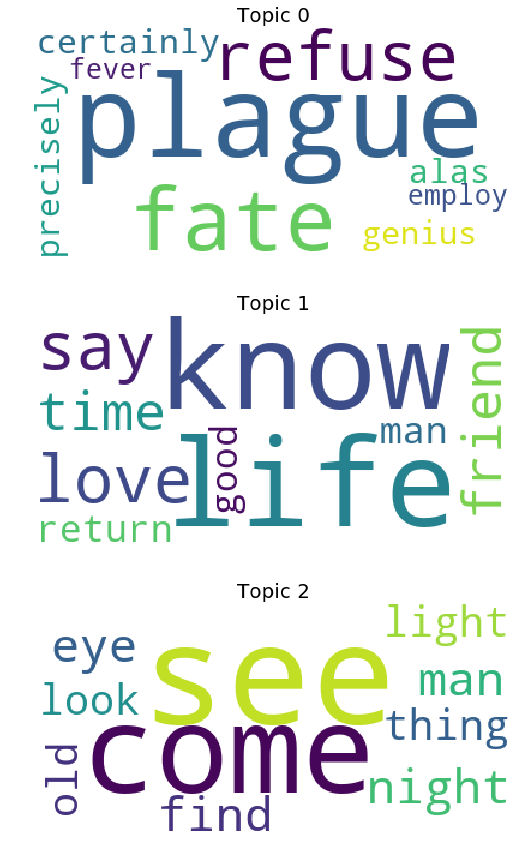

In [64]:
keywords_df = get_keywords_df(lda_model_tfidf)
plot_word_cloud(keywords_df)

# Choose Number of Topic using pyLDAvis

In [67]:
# Too Slow to Run
# %time pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf[:10], dictionary)

# Plot LDA of Each Author

In [71]:
# 
def get_lda_model_tfidf(docs, num_topics=3, passes=5):
    print('Generating Dictionary')
    %time dictionary = create_dictionary(docs)
    print('Size of unfiltered dictionary: {}'.format(len(dictionary)))
    
    print()
    print('Generating BOW')
    corpus_bow = get_corpus_bow(docs, dictionary)
    %time corpus_tfidf, tfidf_model = get_corpus_tfidf(corpus_bow)

    print()
    print('Generating TF-IDF mode')
    %time lda_model_tfidf = gensim.models.LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=passes)
    
    return lda_model_tfidf, corpus_tfidf

In [86]:
index = dataset_df['author'] == 'EAP'
docs_eap = dataset_df[index]['text']
docs_eap[:2]

0    This process, however, afforded me no means of...
2    In his left hand was a gold snuff box, from wh...
Name: text, dtype: object

In [87]:
len(docs_eap)

7900

In [88]:
dataset = docs_eap
%time texts_eap = [preprocess(doc) for doc in nlp.pipe(normalizer(dataset), batch_size=batch_size, n_threads=-1)]

CPU times: user 7.51 s, sys: 3.86 ms, total: 7.51 s
Wall time: 7.51 s


In [89]:
print(len(texts_eap))
print(texts_eap[0])

7900
['process', 'afford', 'means', 'ascertain', 'dimension', 'dungeon', 'circuit', 'return', 'point', 'set', 'aware', 'fact', 'perfectly', 'uniform', 'wall']


In [92]:
lda_model_tfidf_eap, corpus_tfidf_eap = get_lda_model_tfidf(texts_eap)

Generating Dictionary
CPU times: user 130 ms, sys: 0 ns, total: 130 ms
Wall time: 131 ms
Size of unfiltered dictionary: 11623

Generating BOW
CPU times: user 58.9 ms, sys: 0 ns, total: 58.9 ms
Wall time: 59.1 ms

Generating TF-IDF mode
CPU times: user 17.9 s, sys: 56.1 ms, total: 17.9 s
Wall time: 17.9 s


Topic 0: say know hear voice find thing think man good matter
Topic 1: man let heart object little time point truth live feel
Topic 2: come eye minute see foot time shall great head find


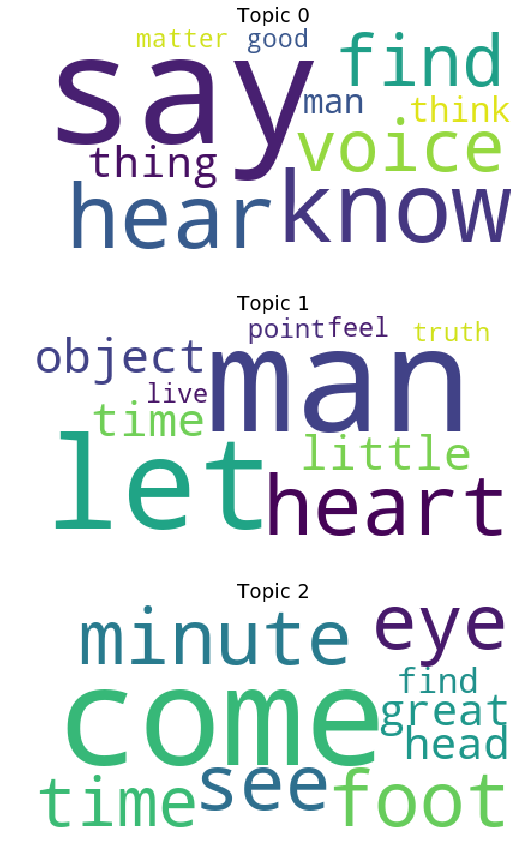

In [93]:
keywords_df = get_keywords_df(lda_model_tfidf_eap)
plot_word_cloud(keywords_df)

# Topic Modeling of Author HPL

In [94]:
index = dataset_df['author'] == 'HPL'
docs = dataset_df[index]['text']
docs[:2]

1    It never once occurred to me that the fumbling...
4    Finding nothing else, not even gold, the Super...
Name: text, dtype: object

In [96]:
dataset = docs
%time texts_author = [preprocess(doc) for doc in nlp.pipe(normalizer(dataset), batch_size=batch_size, n_threads=-1)]

CPU times: user 5.72 s, sys: 0 ns, total: 5.72 s
Wall time: 5.74 s


In [97]:
print(len(texts_author))
print(texts_author[0])

5635
['occur', 'fumbling', 'mere', 'mistake']


In [100]:
print('Generating Dictionary')
%time dictionary = create_dictionary(texts_author)
print('Size of unfiltered dictionary: {}'.format(len(dictionary)))

print()
print('Generating BOW')
corpus_bow = get_corpus_bow(texts_author, dictionary)
%time corpus_tfidf, tfidf_model = get_corpus_tfidf(corpus_bow)

print()
print('Generating TF-IDF mode')
%time lda_model_tfidf = gensim.models.LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=passes)


Generating Dictionary
CPU times: user 103 ms, sys: 3.9 ms, total: 107 ms
Wall time: 107 ms
Size of unfiltered dictionary: 11207

Generating BOW
CPU times: user 54.4 ms, sys: 0 ns, total: 54.4 ms
Wall time: 55.2 ms

Generating TF-IDF mode
CPU times: user 15.3 s, sys: 4.27 ms, total: 15.3 s
Wall time: 15.3 s


Topic 0: night man dream window thing know house see come look
Topic 1: come know thing old man place see think begin find
Topic 2: know thing tell see man old go come time like


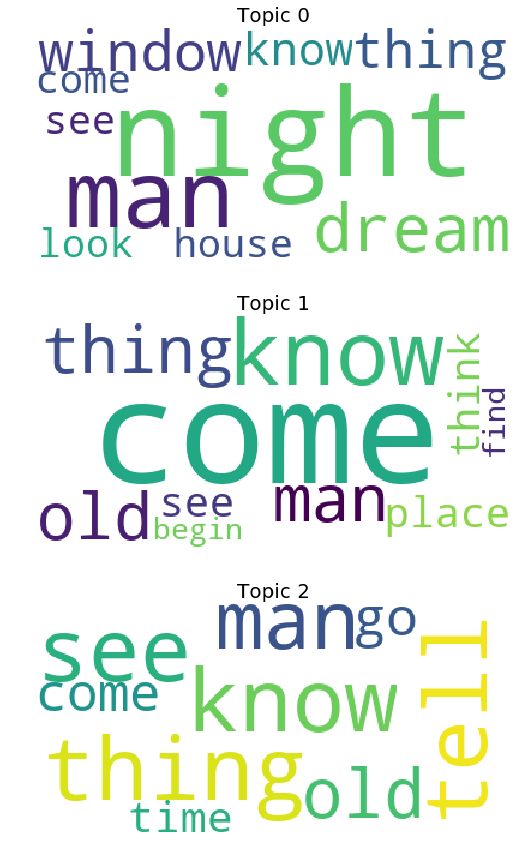

In [101]:
keywords_df = get_keywords_df(lda_model_tfidf)
plot_word_cloud(keywords_df)

# Topic Modeling of Author MWS

In [102]:
index = dataset_df['author'] == 'MWS'
docs = dataset_df[index]['text']
docs[:2]

3    How lovely is spring As we looked from Windsor...
5    A youth passed in solitude, my best years spen...
Name: text, dtype: object

In [103]:
dataset = docs
%time texts_author = [preprocess(doc) for doc in nlp.pipe(normalizer(dataset), batch_size=batch_size, n_threads=-1)]

CPU times: user 5.94 s, sys: 0 ns, total: 5.94 s
Wall time: 5.94 s


In [104]:
print(len(texts_author))
print(texts_author[0])

6044
['lovely', 'spring', 'look', 'windsor', 'terrace', 'fertile', 'county', 'spread', 'beneath', 'speckle', 'happy', 'cottage', 'wealthy', 'town', 'look', 'year', 'heart', 'cheering', 'fair']


In [105]:
print('Generating Dictionary')
%time dictionary = create_dictionary(texts_author)
print('Size of unfiltered dictionary: {}'.format(len(dictionary)))

print()
print('Generating BOW')
corpus_bow = get_corpus_bow(texts_author, dictionary)
%time corpus_tfidf, tfidf_model = get_corpus_tfidf(corpus_bow)

print()
print('Generating TF-IDF mode')
%time lda_model_tfidf = gensim.models.LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=passes)


Generating Dictionary
CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 107 ms
Size of unfiltered dictionary: 8338

Generating BOW
CPU times: user 49.1 ms, sys: 0 ns, total: 49.1 ms
Wall time: 49.1 ms

Generating TF-IDF mode
CPU times: user 12.8 s, sys: 57.5 ms, total: 12.9 s
Wall time: 12.8 s


Topic 0: continue journey public voice lacey man beat de heal possess
Topic 1: month law departure call horrible long misery ruin legislator impose
Topic 2: begin hand world dear discussion present join creation feeling human


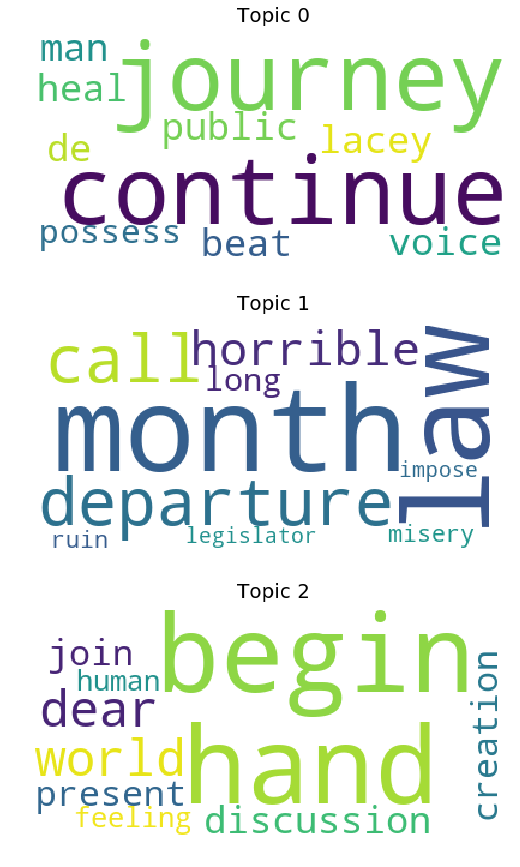

In [106]:
keywords_df = get_keywords_df(lda_model_tfidf)
plot_word_cloud(keywords_df)